## 1. Obtenci√≥n de los datos

En esta secci√≥n, se carga los datos desde la base de datos y se va a convertir la serie temporal de ventas en un ejercicio Supervisado.

### 1.1 Cargar los datos desde la base de datos

Para la conexi√≥n con la base de datos se usa las librer√≠as de `pandas` para mejorar los datos y `sqlalchemy` para la conexi√≥n con al base de datos.

In [ ]:
import pandas as pd
import sqlalchemy as sa


class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "##",
        host: str = "##",
        port: int = ##,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        """Creates a connection to a database

        Args:
            username (str): username
            password (str): password
            dialect (str, optional): dialect. Defaults to "mysql".
            driver (str, optional): driver. Defaults to "pymysql".
            host (str, optional): host. Defaults to "##".
            port (int, optional): port. Defaults to ##.
            database (str, optional): database. Defaults to "data".
        """
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserts a dataframe into a table
        
        Args:
            df (pd.DataFrame): dataframe to insert
            table_name (str): table name
        """
        df.to_sql(table_name, self.engine, if_exists="replace", index=False)

    def query_to_df(self, query: str) -> pd.DataFrame:
        """Retrieves a dataframe from a query.

        Args:
            query (str): query to perform.

        Returns:
            pd.DataFrame: daframe with the results of the query.
        """
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        """Checks if the connection is working

        Returns:
            bool: True if the connection is working, False otherwise
        """
        try:
            self.engine.connect()
        except Exception as e:
            print(e)
            return False

In [ ]:
DB_USERNAME = "###"
DB_PASSWORD = "####"
LOCATION = (###, ###)

Conexi√≥n con la base de datos

In [50]:
database = DatabaseConnection(DB_USERNAME, DB_PASSWORD)
database.check_connection()

Se realiza una consulta SQL para obtener los datos y se comprueba que funciona correctamente con un .info

In [51]:
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM jpra_ventas_diarias_estudio
"""

df = database.query_to_df(query)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10322 non-null  object 
 1   articulo                10322 non-null  object 
 2   fecha_venta             10322 non-null  object 
 3   festivo                 809 non-null    object 
 4   precio                  10322 non-null  float64
 5   cantidad                10322 non-null  float64
 6   importe                 10322 non-null  float64
 7   orden_articulo_familia  10322 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 645.3+ KB


Se muestra los primeros valores.

In [52]:
df.head()

familia articulo fecha_venta festivo  precio  cantidad     importe  \
0  BOLLERIA     3880  2021-05-01    None   2.591   285.000  738.434998   
1  BOLLERIA     3960  2021-05-01    None   2.318   402.000  931.835995   
2  BOLLERIA     5803  2021-05-01    None   2.727   237.000  646.298981   
3  BOLLERIA     6286  2021-05-01    None   3.136   165.000  517.440006   
4  BOLLERIA     6425  2021-05-01    None  31.364    31.725  995.022083   

   orden_articulo_familia  
0                       3  
1                       1  
2                       5  
3                       4  
4                       2

Convertimos las fechas a formato datetime y los art√≠culos a tipo int.

In [53]:
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)

Se organiza los datos por fecha y se reinicia el √≠ndice.

In [54]:
df.sort_values(["fecha_venta"], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

familia  articulo fecha_venta festivo  precio  cantidad     importe  \
0    BOLLERIA      3880  2021-05-01    None   2.591     285.0  738.434998   
1   PANADERIA       417  2021-05-01    None   4.038      72.0  290.736004   
2   PANADERIA      1084  2021-05-01    None   0.865     423.0  365.895005   
3   PANADERIA      1043  2021-05-01    None   2.596     327.0  848.892002   
4  PASTELERIA      5403  2021-05-01    None  34.091       3.0  102.273003   

   orden_articulo_familia  
0                       3  
1                       5  
2                       4  
3                       2  
4                       2

Nota: Todo lo relacionado al EDA est√° en el notebook [EDA](./DataScience-Project/Datathon_Bakery/2.%20EDA.ipynb)

### 1.2 Convertir la serie en formato supervisado

Para predecir las ventas, se necesita transformar los datos a un problema supervisado, para ello:    
- Se deber√° obtener la `cantidad` contabilizada de los d√≠as anteriores y a√±adirlos al d√≠a presente.
- Se deber√° obtener `cantidad` contabilizada de las semanas anteriores y a√±adirlos al d√≠a presente.

Se dise√±a una funci√≥n que permite transformar la serie a formato supervisado.
La funci√≥n recibe como par√°metros el dataframe, n√∫mero de d√≠as y semanas a considerar. 

In [55]:
def multi_product_series_to_supervised(
    df: pd.DataFrame,
    target_column: str = "cantidad",
    id_column: str = "articulo",
    daily_lag: int = 1,
    weekly_lag: int = 1,
) -> pd.DataFrame:
    """
    Converts multiple time series (grouped by product) into a supervised learning dataset.
    
    Args:
        df: Input DataFrame with columns: fecha_venta, articulo, cantidad, etc.
        target_column: Name of the target variable column (default: "cantidad").
        id_column: Name of the column identifying products (default: "articulo").
        daily_lag: Number of daily lags to include (default: 1).
        weekly_lag: Number of weekly lags to include (default: 1).
    
    Returns:
        DataFrame with lagged features for each product.
    """
    # Verificar que la columna de fecha existe
    if 'fecha_venta' not in df.columns:
        raise ValueError("El DataFrame debe contener una columna 'fecha_venta'.")

    resultados = []
    
    # Ordenar por art√≠culo y fecha
    df = df.sort_values([id_column, 'fecha_venta'])
    
    for articulo in df[id_column].unique():
        # Filtrar datos para el art√≠culo actual
        df_articulo = df[df[id_column] == articulo].copy()
        
        # Crear caracter√≠sticas de lag para este art√≠culo
        target_feature = df_articulo[target_column]
        
        # Funci√≥n interna para crear lags
        def create_shifted_feature(lag: int, frequency: int, freq_label: str):
            shifted_feature = target_feature.shift(lag * frequency)
            feature_name = f"{target_column}_lag_{lag}_{freq_label}"
            df_articulo[feature_name] = shifted_feature
        
        # A√±adir lags semanales (t-7, t-14, ...)
        for lag in range(1, weekly_lag + 1):
            create_shifted_feature(lag, 7, "weeks")
        
        # A√±adir lags diarios (t-1, t-2, ...)
        for lag in range(1, daily_lag + 1):
            create_shifted_feature(lag, 1, "days")
        
        resultados.append(df_articulo)
    
    # Combinar todos los DataFrames y resetear √≠ndice
    return pd.concat(resultados).reset_index(drop=True)

In [56]:
df_supervised = multi_product_series_to_supervised(
    df=df,  # <- Aqu√≠ usas tu DataFrame real
    target_column="cantidad",
    id_column="articulo",
    daily_lag=6,  # Lags diarios: t-1, t-2, ..., t-6
    weekly_lag=4   # Lags semanales: t-7, t-14, t-21, t-28
)
df_supervised.head()

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       417  2021-05-01             None   4.038      72.0   
1  PANADERIA       417  2021-05-02  D√≠a de la Madre   4.038      81.0   
2  PANADERIA       417  2021-05-03   D√≠a de la Cruz   4.038      90.0   
3  PANADERIA       417  2021-05-04             None   4.038      84.0   
4  PANADERIA       417  2021-05-05             None   4.038      84.0   

      importe  orden_articulo_familia  cantidad_lag_1_weeks  \
0  290.736004                       5                   NaN   
1  327.077995                       5                   NaN   
2  363.419998                       5                   NaN   
3  339.192001                       5                   NaN   
4  339.192003                       5                   NaN   

   cantidad_lag_2_weeks  cantidad_lag_3_weeks  cantidad_lag_4_weeks  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   cantidad_lag_1_days  cantidad_lag_2_days  cantidad_lag_3_days  \
0                  NaN                  NaN                  NaN   
1                 72.0                  NaN                  NaN   
2                 81.0                 72.0                  NaN   
3                 90.0                 81.0                 72.0   
4                 84.0                 90.0                 81.0   

   cantidad_lag_4_days  cantidad_lag_5_days  cantidad_lag_6_days  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2                  NaN                  NaN                  NaN  
3                  NaN                  NaN                  NaN  
4                 72.0                  NaN                  NaN

In [57]:
df_supervised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   festivo                 809 non-null    object        
 4   precio                  10322 non-null  float64       
 5   cantidad                10322 non-null  float64       
 6   importe                 10322 non-null  float64       
 7   orden_articulo_familia  10322 non-null  int64         
 8   cantidad_lag_1_weeks    10217 non-null  float64       
 9   cantidad_lag_2_weeks    10112 non-null  float64       
 10  cantidad_lag_3_weeks    10007 non-null  float64       
 11  cantidad_lag_4_weeks    9902 non-null   float64       
 12  cantidad_lag_1_days     10307 non-null  float6

## 2. Procesamiento de los datos

En este paso se crear√° un Flujo de Transformaci√≥n de Datos (Data Pipeline).

### 2.1 Extraer info de la fecha de venta

Con este campo se va a crear las siguientes columnas:

- dayofweek: D√≠a de la semana.
- day: D√≠a del mes.
- month: El mes.
- year: El a√±o.
- weekend: Si es fin de semana.

Se va a crear la siguiente funci√≥n para extraer los nuevos campos y adicionarlos al df.

In [58]:
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1
    df["isWeekend"] = df["dayofweek"] >= 6
    return df

df_supervised_tmp = add_date_columns(df_supervised.copy())
df_supervised_tmp.head()

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       417  2021-05-01             None   4.038      72.0   
1  PANADERIA       417  2021-05-02  D√≠a de la Madre   4.038      81.0   
2  PANADERIA       417  2021-05-03   D√≠a de la Cruz   4.038      90.0   
3  PANADERIA       417  2021-05-04             None   4.038      84.0   
4  PANADERIA       417  2021-05-05             None   4.038      84.0   

      importe  orden_articulo_familia  cantidad_lag_1_weeks  \
0  290.736004                       5                   NaN   
1  327.077995                       5                   NaN   
2  363.419998                       5                   NaN   
3  339.192001                       5                   NaN   
4  339.192003                       5                   NaN   

   cantidad_lag_2_weeks  ...  cantidad_lag_2_days  cantidad_lag_3_days  \
0                   NaN  ...                  NaN                  NaN   
1                   NaN  ...                  NaN                  NaN   
2                   NaN  ...                 72.0                  NaN   
3                   NaN  ...                 81.0                 72.0   
4                   NaN  ...                 90.0                 81.0   

   cantidad_lag_4_days  cantidad_lag_5_days  cantidad_lag_6_days  day  month  \
0                  NaN                  NaN                  NaN    1      5   
1                  NaN                  NaN                  NaN    2      5   
2                  NaN                  NaN                  NaN    3      5   
3                  NaN                  NaN                  NaN    4      5   
4                 72.0                  NaN                  NaN    5      5   

   year  dayofweek  isWeekend  
0  2021          6       True  
1  2021          7       True  
2  2021          1      False  
3  2021          2      False  
4  2021          3      False  

[5 rows x 23 columns]

### 2.2 Agregar columnas adicionales

Se agrega las siguientes columnas:

- `isHoliday`: Indica con un True y False si es un d√≠a festivo o no.
- `isBridgeDay`: Solo aplica para d√≠as que son puentes cuando el festivo es un jueves, el valor se marcar√° True un viernes y si el festivo es martes, el lunes se marcar√° como True.
- `preHoliday`: Indica True si el d√≠a es un d√≠a anterior a un festivo.
- `postHoliday`: Indica True si hay un festivo el d√≠a anterior.

Adem√°s la funci√≥n elimina la columna de `festivo` porque ya se est√° usando la columna `isHoliday`


In [59]:
from datetime import timedelta
import pandas as pd

def add_holiday_features(
    df: pd.DataFrame,
    date_column: str = "fecha_venta",
    raw_holiday_column: str = "festivo",
    holiday_column: str = "isHoliday"
) -> pd.DataFrame:
    """
    A√±ade columna booleana de festivo (`isHoliday`) y contexto:
    - isBridgeDay: Viernes si el festivo es jueves, o lunes si es martes.
    - preHoliday: D√≠a anterior a un festivo.
    - postHoliday: D√≠a posterior a un festivo.
    """
    df = df.copy()

    # Convertir fechas si es necesario
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Crear columna isHoliday desde la columna original de festivos
    if raw_holiday_column in df.columns:
        df[holiday_column] = ~df[raw_holiday_column].isna()
        df.drop(columns=[raw_holiday_column], inplace=True)
    else:
        print(f"Advertencia: Columna '{raw_holiday_column}' no encontrada. No se marcar√°n festivos.")
        df[holiday_column] = False

    # Inicializar columnas de contexto
    df["isBridgeDay"] = False
    df["preHoliday"] = False
    df["postHoliday"] = False

    # Identificar fechas festivas
    holiday_dates = df.loc[df[holiday_column], date_column].dropna().unique()

    for holiday in holiday_dates:
        try:
            holiday = pd.to_datetime(holiday)

            pre_day = holiday - timedelta(days=1)
            post_day = holiday + timedelta(days=1)

            df.loc[df[date_column] == pre_day, "preHoliday"] = True
            df.loc[df[date_column] == post_day, "postHoliday"] = True

            if holiday.weekday() == 3:  # Jueves -> puente viernes
                df.loc[df[date_column] == (holiday + timedelta(days=1)), "isBridgeDay"] = True
            elif holiday.weekday() == 1:  # Martes -> puente lunes
                df.loc[df[date_column] == (holiday - timedelta(days=1)), "isBridgeDay"] = True

        except Exception as e:
            print(f"Error procesando fecha {holiday}: {str(e)}")

    return df


df_supervised_tmp = add_holiday_features(df_supervised.copy())
df_supervised_tmp.head()

familia  articulo fecha_venta  precio  cantidad     importe  \
0  PANADERIA       417  2021-05-01   4.038      72.0  290.736004   
1  PANADERIA       417  2021-05-02   4.038      81.0  327.077995   
2  PANADERIA       417  2021-05-03   4.038      90.0  363.419998   
3  PANADERIA       417  2021-05-04   4.038      84.0  339.192001   
4  PANADERIA       417  2021-05-05   4.038      84.0  339.192003   

   orden_articulo_familia  cantidad_lag_1_weeks  cantidad_lag_2_weeks  \
0                       5                   NaN                   NaN   
1                       5                   NaN                   NaN   
2                       5                   NaN                   NaN   
3                       5                   NaN                   NaN   
4                       5                   NaN                   NaN   

   cantidad_lag_3_weeks  ...  cantidad_lag_1_days  cantidad_lag_2_days  \
0                   NaN  ...                  NaN                  NaN   
1                   NaN  ...                 72.0                  NaN   
2                   NaN  ...                 81.0                 72.0   
3                   NaN  ...                 90.0                 81.0   
4                   NaN  ...                 84.0                 90.0   

   cantidad_lag_3_days  cantidad_lag_4_days  cantidad_lag_5_days  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                 72.0                  NaN                  NaN   
4                 81.0                 72.0                  NaN   

   cantidad_lag_6_days  isHoliday  isBridgeDay  preHoliday  postHoliday  
0                  NaN      False        False        True        False  
1                  NaN       True        False        True        False  
2                  NaN       True        False       False         True  
3                  NaN      False        False       False         True  
4                  NaN      False        False       False        False  

[5 rows x 21 columns]

### 2.3 Se agrega Informaci√≥n meteorol√≥gica


Se utiliza la API de meteostat para obtener los datos meteorol√≥gicos.
Se a√±adir√° la columna `isRaining` para indicar si ese d√≠a hubo lluvia o no. Los valores ser√°n verdader o falso.

In [60]:
from datetime import datetime
from meteostat import Point, Daily
import numpy as np


def get_weather_df(start: datetime, end: datetime, location: tuple[int, int]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

def add_weather_columns(
    df: pd.DataFrame,
    location: tuple[int, int],
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_df(start, end, location)
    weather_df = add_rain_column(weather_df)
    weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
    return weather_df


df_supervised_tmp = df_supervised.copy()
add_weather_columns(df_supervised, LOCATION).head()


familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       417  2021-05-01             None   4.038      72.0   
1  PANADERIA       417  2021-05-02  D√≠a de la Madre   4.038      81.0   
2  PANADERIA       417  2021-05-03   D√≠a de la Cruz   4.038      90.0   
3  PANADERIA       417  2021-05-04             None   4.038      84.0   
4  PANADERIA       417  2021-05-05             None   4.038      84.0   

      importe  orden_articulo_familia  cantidad_lag_1_weeks  \
0  290.736004                       5                   NaN   
1  327.077995                       5                   NaN   
2  363.419998                       5                   NaN   
3  339.192001                       5                   NaN   
4  339.192003                       5                   NaN   

   cantidad_lag_2_weeks  ...  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
0                   NaN  ...  11.9  22.8   0.0   0.0   0.0  14.2   0.0   
1                   NaN  ...  10.8  23.2   0.0   0.0   0.0  15.7   0.0   
2                   NaN  ...  12.7  20.1   6.5   0.0   0.0   9.7   0.0   
3                   NaN  ...  12.0  20.9   0.0   0.0   0.0  12.1   0.0   
4                   NaN  ...  12.3  21.7   0.0   0.0   0.0  13.8   0.0   

     pres tsun  isRaining  
0  1014.0  0.0      False  
1  1015.9  0.0      False  
2  1017.7  0.0       True  
3  1018.0  0.0      False  
4  1016.5  0.0      False  

[5 rows x 30 columns]

In [61]:
##
# Crear una copia independiente del DataFrame original
df_final = df_supervised.copy()

# Aplicar las funciones en secuencia
df_final = add_date_columns(df_final)
df_final = add_holiday_features(df_final)
df_final = add_weather_columns(df_final, location=LOCATION) 

df_final.head()

familia  articulo fecha_venta  precio  cantidad     importe  \
0  PANADERIA       417  2021-05-01   4.038      72.0  290.736004   
1  PANADERIA       417  2021-05-02   4.038      81.0  327.077995   
2  PANADERIA       417  2021-05-03   4.038      90.0  363.419998   
3  PANADERIA       417  2021-05-04   4.038      84.0  339.192001   
4  PANADERIA       417  2021-05-05   4.038      84.0  339.192003   

   orden_articulo_familia  cantidad_lag_1_weeks  cantidad_lag_2_weeks  \
0                       5                   NaN                   NaN   
1                       5                   NaN                   NaN   
2                       5                   NaN                   NaN   
3                       5                   NaN                   NaN   
4                       5                   NaN                   NaN   

   cantidad_lag_3_weeks  ...  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
0                   NaN  ...  11.9  22.8   0.0   0.0   0.0  14.2   0.0   
1                   NaN  ...  10.8  23.2   0.0   0.0   0.0  15.7   0.0   
2                   NaN  ...  12.7  20.1   6.5   0.0   0.0   9.7   0.0   
3                   NaN  ...  12.0  20.9   0.0   0.0   0.0  12.1   0.0   
4                   NaN  ...  12.3  21.7   0.0   0.0   0.0  13.8   0.0   

     pres  tsun  isRaining  
0  1014.0   0.0      False  
1  1015.9   0.0      False  
2  1017.7   0.0       True  
3  1018.0   0.0      False  
4  1016.5   0.0      False  

[5 rows x 38 columns]

## 3. Creaci√≥n de Pipeline

### 3.1 Preprocesamiento de los datos de entrada

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin


class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[int, int], daily_lag: int, weekly_lag: int):
        self.location = location
        self.daily_lag = daily_lag
        self.weekly_lag = weekly_lag

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()  # avoid modifying incoming data
        X = add_date_columns(X)
        X = add_holiday_features(X)
        X = add_weather_columns(X, location=self.location)
        return X

In [63]:
##
from sklearn.base import TransformerMixin, BaseEstimator, OneToOneFeatureMixin

class PreprocessTransformer(OneToOneFeatureMixin, BaseEstimator, TransformerMixin):
    def __init__(self, location: tuple[int, int], daily_lag: int, weekly_lag: int):
        self.location = location
        self.daily_lag = daily_lag
        self.weekly_lag = weekly_lag

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        # A√±adir features
        X = add_date_columns(X)
        X = add_holiday_features(X)
        X = add_weather_columns(X, location=self.location)
        
        # --- Limpieza dentro del transformador ---
        # Eliminar columnas problem√°ticas
        cols_to_drop = [
            'fecha_venta', 'time', 'articulo', 'familia',  # No num√©ricas
            'snow', 'wdir', 'wpgt', 'pres', 'tsun',  # Meteorol√≥gicas irrelevantes
            'festivo'  # Redundante con isHoliday
        ]
        return X.drop(columns=cols_to_drop, errors='ignore')

In [65]:
preprocessor = PreprocessTransformer(location=LOCATION, daily_lag=6, weekly_lag=4)
preprocessed_df = preprocessor.transform(df_supervised)
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10322 entries, 0 to 10321
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   precio                  10322 non-null  float64       
 4   cantidad                10322 non-null  float64       
 5   importe                 10322 non-null  float64       
 6   orden_articulo_familia  10322 non-null  int64         
 7   cantidad_lag_1_weeks    10217 non-null  float64       
 8   cantidad_lag_2_weeks    10112 non-null  float64       
 9   cantidad_lag_3_weeks    10007 non-null  float64       
 10  cantidad_lag_4_weeks    9902 non-null   float64       
 11  cantidad_lag_1_days     10307 non-null  float64       
 12  cantidad_lag_2_days     10292 non-null  float64    

### 3.2 Normalizaci√≥n de los datos de entrada

Antes de hacer indicar los valores, se eliminaran las siguientes columnas porque no aportan ning√∫n valor en nuestro dataframe, ya que √©stas columnas tienen valores 0 `snow`, `wdir` y `tsun`.

Y la columna `prcp` porque se utiliz√≥ para crear la columna `isRaining`

In [77]:
preprocessed_df = preprocessed_df.drop(columns=["snow", "wdir", "tsun", "prcp"])
preprocessed_df.columns

Index(['familia', 'articulo', 'fecha_venta', 'precio', 'cantidad', 'importe',
       'orden_articulo_familia', 'cantidad_lag_1_weeks',
       'cantidad_lag_2_weeks', 'cantidad_lag_3_weeks', 'cantidad_lag_4_weeks',
       'cantidad_lag_1_days', 'cantidad_lag_2_days', 'cantidad_lag_3_days',
       'cantidad_lag_4_days', 'cantidad_lag_5_days', 'cantidad_lag_6_days',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday',
       'isBridgeDay', 'preHoliday', 'postHoliday', 'time', 'tavg', 'tmin',
       'tmax', 'wspd', 'wpgt', 'pres', 'isRaining'],
      dtype='object')

Para la normalizaci√≥n de los datos se utiliza `OneHotEncoder` para las variables categoricas y `MinMaxScaler`. para las variables num√©ricas.

In [66]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector


categorical_features = make_column_selector(dtype_include=[object, np.int32])
numerical_features = make_column_selector(dtype_include=[np.float64])

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
)

### 3.3 Eliminar los valores nulos

En este paso se rellena los valores nulos calculando la media de cada columna.

In [67]:
from sklearn.impute import SimpleImputer


nans_remover = SimpleImputer(strategy="mean")
remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
)


### 3.4 Incluir el modelo de Machine Learning

Como nos encontramos en un problema de regresi√≥n porque se quiere predecir las cantidades vendidas, se va a utilizar un modelo de regresi√≥n. En este caso, vamos a utilizar el modelo `LinearRegression` de Scikit-Learn.

In [68]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

### 3.5 Creamos el pipeline para las variables de entrada

Se agrega los pasos anteriores al pipeline de transformaci√≥n de datos de forma secuencial. El pipeline se encargar√° de aplicar las transformaciones a los datos de entrada y de entrenar el modelo.

In [69]:
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 PreprocessTransformer(daily_lag=6,
                                       location=(36.721477644071705,
                                                 -4.363132134392174),
                                       weekly_lag=4)),
                ('nan_remover',
                 ColumnTransformer(transformers=[('RemoveNans', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1280929d0>)])),
                ('data_encoding',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x128668d10>),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1280929d0>)])),
                ('model', LinearRegression())])

### 3.6 Normalizar la variable objetivo

En ultimo paso, se usa el mismo `OneHotEncoder` utilizado para los datos de entrada para codificar la variable objetivo (target), pero sin ajustarlo nuevamente. Esto asegura que la variable objetivo est√© en el mismo formato que los datos de entrada, facilitando as√≠ la predicci√≥n y evaluaci√≥n del modelo.

In [70]:
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      PreprocessTransformer(daily_lag=6,
                                                                            location=(36.721477644071705,
                                                                                      -4.363132134392174),
                                                                            weekly_lag=4)),
                                                     ('nan_remover',
                                                      ColumnTransformer(transformers=[('RemoveNans',
                                                                                       SimpleImputer(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x1280929d0>)])),
                                                     ('data_encoding',
                                                      ColumnTransformer(transformers=[('OneHotEncoder',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x128668d10>),
                                                                                      ('MinMaxScaler',
                                                                                       MinMaxScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x1280929d0>)])),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=MinMaxScaler())

## 4. Entrenar el modelo

Se utiliza el pipeline creado anteriormente para entrenar el modelo. Marcamos el horizonte de tiempo del conjunto de test a 30 d√≠as. Esto significa que el modelo se evaluar√° con los datos de los √∫ltimos 30 d√≠as y se entrenar√° con los datos previos a dicho horizonte.

Se entrena el modelo por art√≠culos porque no todos los art√≠culos dentro de las familias se comportan de la misma manera.

In [71]:
def split_by_article(df: pd.DataFrame, article_col: str = "articulo") -> dict[int, pd.DataFrame]:
    """
    Divide el DataFrame en diccionario de DataFrames, uno por art√≠culo.
    
    Args:
        df: DataFrame con todos los datos.
        article_col: Nombre de la columna que contiene los IDs de art√≠culos.
    
    Returns:
        Un diccionario donde las claves son los IDs de art√≠culos y los valores son DataFrames filtrados.
    """
    articles = df[article_col].unique()
    return {article: df[df[article_col] == article].copy() for article in articles}

In [72]:
dict_articulos = split_by_article(df_final, article_col="articulo")

In [73]:
print("Art√≠culos disponibles:", dict_articulos.keys())

Art√≠culos disponibles: dict_keys([np.int64(417), np.int64(900), np.int64(968), np.int64(1043), np.int64(1084), np.int64(3880), np.int64(3960), np.int64(5403), np.int64(5404), np.int64(5803), np.int64(6286), np.int64(6425), np.int64(6451), np.int64(6523), np.int64(6549)])


Se asignar√° los df creados en valores para poder entrenarlos por art√≠culo

In [74]:
df_articulo_417 = dict_articulos[417]
df_articulo_900 = dict_articulos[900]
df_articulo_968 = dict_articulos[968]
df_articulo_1043 = dict_articulos[1043]
df_articulo_1084 = dict_articulos[1084]
df_articulo_3880 = dict_articulos[3880]
df_articulo_3960 = dict_articulos[3960]
df_articulo_5403 = dict_articulos[5403]
df_articulo_5404 = dict_articulos[5404]
df_articulo_5803 = dict_articulos[5803]
df_articulo_6286 = dict_articulos[6286]
df_articulo_6425 = dict_articulos[6425]
df_articulo_6451 = dict_articulos[6451]
df_articulo_6523 = dict_articulos[6523]
df_articulo_6549 = dict_articulos[6549]


In [255]:
df_articulo_1043.head()

familia  articulo fecha_venta  precio  cantidad     importe  \
2190  PANADERIA      1043  2021-05-01   2.596     327.0  848.892002   
2191  PANADERIA      1043  2021-05-02   2.596     303.0  786.587997   
2192  PANADERIA      1043  2021-05-03   2.596     216.0  560.735996   
2193  PANADERIA      1043  2021-05-04   2.596     177.0  459.491999   
2194  PANADERIA      1043  2021-05-05   2.596     180.0  467.279993   

      orden_articulo_familia  cantidad_lag_1_weeks  cantidad_lag_2_weeks  \
2190                       2                   NaN                   NaN   
2191                       2                   NaN                   NaN   
2192                       2                   NaN                   NaN   
2193                       2                   NaN                   NaN   
2194                       2                   NaN                   NaN   

      cantidad_lag_3_weeks  ...  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
2190                   NaN  ...  11.9  22.8   0.0   0.0   0.0  14.2   0.0   
2191                   NaN  ...  10.8  23.2   0.0   0.0   0.0  15.7   0.0   
2192                   NaN  ...  12.7  20.1   6.5   0.0   0.0   9.7   0.0   
2193                   NaN  ...  12.0  20.9   0.0   0.0   0.0  12.1   0.0   
2194                   NaN  ...  12.3  21.7   0.0   0.0   0.0  13.8   0.0   

        pres  tsun  isRaining  
2190  1014.0   0.0      False  
2191  1015.9   0.0      False  
2192  1017.7   0.0       True  
2193  1018.0   0.0      False  
2194  1016.5   0.0      False  

[5 rows x 38 columns]

Se guarda la familia a la que pertennece el producto para guaradrlo como tag en MLFlow

### 4.1 Peque√±a limpieza de los datos

Se elimina columnas que no se van a utilizar en el modelo

In [75]:
drop_cols = ['importe', 'articulo', 'familia', 'orden_articulo_familia',"snow", "wdir", "tsun", "prcp"]

df_articulo_417 = df_articulo_417.drop(columns=drop_cols)
df_articulo_900 = df_articulo_900.drop(columns=drop_cols)
df_articulo_968 = df_articulo_968.drop(columns=drop_cols)
df_articulo_1043 =df_articulo_1043.drop(columns=drop_cols)
df_articulo_1084 =df_articulo_1084.drop(columns=drop_cols)
df_articulo_3880 =df_articulo_3880.drop(columns=drop_cols)
df_articulo_3960 =df_articulo_3960.drop(columns=drop_cols)
df_articulo_5403 =df_articulo_5403.drop(columns=drop_cols)
df_articulo_5404 =df_articulo_5404.drop(columns=drop_cols)
df_articulo_5803 =df_articulo_5803.drop(columns=drop_cols)
df_articulo_6286 =df_articulo_6286.drop(columns=drop_cols)
df_articulo_6425 =df_articulo_6425.drop(columns=drop_cols)
df_articulo_6451 =df_articulo_6451.drop(columns=drop_cols)
df_articulo_6523 =df_articulo_6523.drop(columns=drop_cols)
df_articulo_6549 =df_articulo_6549.drop(columns=drop_cols)

dfs_articulos = {
    417: df_articulo_417,
    900: df_articulo_900,
    968: df_articulo_968,
    1043: df_articulo_1043,
    1084: df_articulo_1084,
    3880: df_articulo_3880,
    3960: df_articulo_3960,
    5403: df_articulo_5403,
    5404: df_articulo_5404,
    5803: df_articulo_5803,
    6286: df_articulo_6286,
    6425: df_articulo_6425,
    6451: df_articulo_6451,
    6523: df_articulo_6523,
    6549: df_articulo_6549
}

In [76]:
dfs_articulos[417].columns

Index(['fecha_venta', 'precio', 'cantidad', 'cantidad_lag_1_weeks',
       'cantidad_lag_2_weeks', 'cantidad_lag_3_weeks', 'cantidad_lag_4_weeks',
       'cantidad_lag_1_days', 'cantidad_lag_2_days', 'cantidad_lag_3_days',
       'cantidad_lag_4_days', 'cantidad_lag_5_days', 'cantidad_lag_6_days',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday',
       'isBridgeDay', 'preHoliday', 'postHoliday', 'time', 'tavg', 'tmin',
       'tmax', 'wspd', 'wpgt', 'pres', 'isRaining'],
      dtype='object')

### 4.2. Se divide en conjuntos de entrenamiento y test.

In [77]:
from datetime import datetime


# DICCIONARIO CON LOS DATAFRAMES
dfs_articulos 

# --- C√ìDIGO MODIFICADO ---
# La funci√≥n de preparaci√≥n de datos ahora se encarga solo de la partici√≥n de los datos
def preparar_datos_para_modelado(
    dfs_articulos: dict,
    target_col: str = "cantidad",
    horizont: datetime = datetime(2023, 3, 31)
) -> dict:
    resultados = {}
    for id_articulo, df in dfs_articulos.items():
        try:
            mask_train = df["fecha_venta"] < horizont
            mask_test = df["fecha_venta"] >= horizont

            df_train = df.loc[mask_train].copy()
            df_test = df.loc[mask_test].copy()
            
            # Aqu√≠ es donde realmente usas 'fecha_venta' para el split, despu√©s ya no se necesita.
            X_train = df_train.drop(columns=[target_col])
            y_train = df_train[target_col]
            X_test = df_test.drop(columns=[target_col])
            y_test = df_test[target_col]

            resultados[id_articulo] = {
                "X_train": X_train,
                "y_train": y_train,
                "X_test": X_test,
                "y_test": y_test
            }
        except Exception as e:
            print(f"‚ùå Error procesando art√≠culo {id_articulo}: {str(e)}")

    return resultados

# Ejecuta la preparaci√≥n de datos con la funci√≥n modificada
datos_preparados = preparar_datos_para_modelado(dfs_articulos)




Se define la familia para poder guardarlo como un tag en MLFlow

In [78]:
familias_por_articulo = {
    3960: "BOLLERIA",
    5803: "BOLLERIA",
    3880: "BOLLERIA",
    6286: "BOLLERIA",
    6425: "BOLLERIA",
    1084: "PANADERIA",
    417: "PANADERIA", 
    900: "PANADERIA",
    968: "PANADERIA",
    1043: "PANADERIA",
    6451: "PASTELERIA",
    6549: "PASTELERIA",
    6523: "PASTELERIA",
    5403: "PASTELERIA",
    5404: "PASTELERIA"
}

In [47]:
type(familias_por_articulo)

set

### 4.3 Iniciar el servidor de MLFlow

In [79]:
import mlflow

# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Datathon V"
MLFLOW_TRACKING_URI = "http://localhost:5050"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/785527324255991079', creation_time=1755012200772, experiment_id='785527324255991079', last_update_time=1755012200772, lifecycle_stage='active', name='Datathon V', tags={}>

In [80]:
print("‚úÖ Pipeline configurado correctamente:")
print(final_pipeline)

‚úÖ Pipeline configurado correctamente:
TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      PreprocessTransformer(daily_lag=6,
                                                                            location=(36.721477644071705,
                                                                                      -4.363132134392174),
                                                                            weekly_lag=4)),
                                                     ('nan_remover',
                                                      ColumnTransformer(transformers=[('RemoveNans',
                                                                                       SimpleImputer(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x1280929d0>)])),
                                                 

In [81]:
import mlflow
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- C√ìDIGO MODIFICADO ---
def entrenar_modelo_final(id_articulo, datos_articulo):
    try:
        with mlflow.start_run(run_name=f"Art√≠culo_{id_articulo}"):
            X_train = datos_articulo["X_train"]
            y_train = datos_articulo["y_train"]
            X_test = datos_articulo["X_test"]
            y_test = datos_articulo["y_test"]

            # Ya no es necesario el filtro de columnas, el pipeline lo maneja
            # X_train = X_train.select_dtypes(...)
            # X_test = X_test.select_dtypes(...)
            
            if len(X_train) == 0 or len(X_test) == 0:
                print(f"‚ö†Ô∏è Art√≠culo {id_articulo}: Sin datos suficientes")
                return None
            
            print(f"Tipo de familias_por_articulo: {type(familias_por_articulo)}")
            familia = familias_por_articulo.get(id_articulo, "Desconocida")
            print(f"Familia para art√≠culo {id_articulo}: {familia}")

            familia = familias_por_articulo.get(id_articulo, "Desconocida")
            mlflow.set_tags({
                "articulo": str(id_articulo),
                "familia": familia,
                "modelo": "LinearRegression+PipelineCompleto"
            })
            
            final_pipeline.fit(X_train, y_train)
            
            y_pred = final_pipeline.predict(X_test)
            
            metrics = {
                "mae_test": mean_absolute_error(y_test, y_pred),
                "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred)),
                "r2_test": r2_score(y_test, y_pred)
            }
            
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(final_pipeline, "model")
            
            print(f"‚úÖ {id_articulo} ({familia}) - MAE: {metrics['mae_test']:.2f}")
            return metrics
            
    except Exception as e:
        print(f"‚ùå Error en art√≠culo {id_articulo}: {str(e)}")
        return None

# --- Bucle para entrenar los modelos ---
resultados_finales = {}
for id_articulo, datos_articulo in datos_preparados.items():
    print(f"\nüîç Procesando art√≠culo {id_articulo}...")
    resultado = entrenar_modelo_final(id_articulo, datos_articulo)
    if resultado is not None:
        resultados_finales[id_articulo] = resultado

# Mostrar resumen
print("\nüéØ Resultados Finales:")
for art, res in resultados_finales.items():
    print(f"Art√≠culo {art}: MAE={res['mae_test']:.2f} | R¬≤={res['r2_test']:.2f}")



üîç Procesando art√≠culo 417...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 417: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 417 (PANADERIA) - MAE: 9.94
üèÉ View run Art√≠culo_417 at: http://localhost:5050/#/experiments/785527324255991079/runs/103e7ea70c4642bab448908128257c6d
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 900...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 900: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 900 (PANADERIA) - MAE: 84.23
üèÉ View run Art√≠culo_900 at: http://localhost:5050/#/experiments/785527324255991079/runs/5e2fb258526041a1911d2e2b4e635208
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 968...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 968: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 968 (PANADERIA) - MAE: 37.21
üèÉ View run Art√≠culo_968 at: http://localhost:5050/#/experiments/785527324255991079/runs/8a92e801b5534ab89ea13ad97d4a715e
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 1043...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 1043: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 1043 (PANADERIA) - MAE: 45.33
üèÉ View run Art√≠culo_1043 at: http://localhost:5050/#/experiments/785527324255991079/runs/17c00be830604e268e15719be8e65ec0
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 1084...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 1084: PANADERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 1084 (PANADERIA) - MAE: 42.91
üèÉ View run Art√≠culo_1084 at: http://localhost:5050/#/experiments/785527324255991079/runs/ab736b6264eb4dd69adcb6d8be77d756
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 3880...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 3880: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 3880 (BOLLERIA) - MAE: 27.40
üèÉ View run Art√≠culo_3880 at: http://localhost:5050/#/experiments/785527324255991079/runs/104a750890a248238c8ba20671bd49ac
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 3960...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 3960: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 3960 (BOLLERIA) - MAE: 36.19
üèÉ View run Art√≠culo_3960 at: http://localhost:5050/#/experiments/785527324255991079/runs/3eb30c9e064f4aeab11b75268fe73f7b
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 5403...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 5403: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 5403 (PASTELERIA) - MAE: 9.05
üèÉ View run Art√≠culo_5403 at: http://localhost:5050/#/experiments/785527324255991079/runs/a4eefe1966c2481ca0a8e58f7c90be4c
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 5404...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 5404: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 5404 (PASTELERIA) - MAE: 9.64
üèÉ View run Art√≠culo_5404 at: http://localhost:5050/#/experiments/785527324255991079/runs/db892114a35a437fbfc40ab6957b8487
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 5803...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 5803: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 5803 (BOLLERIA) - MAE: 21.80
üèÉ View run Art√≠culo_5803 at: http://localhost:5050/#/experiments/785527324255991079/runs/484587d1f5db4b3a828032ada53c6e25
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 6286...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 6286: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 6286 (BOLLERIA) - MAE: 20.82
üèÉ View run Art√≠culo_6286 at: http://localhost:5050/#/experiments/785527324255991079/runs/ce84eae1c4ba4ab78e8da7d8e126c518
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 6425...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 6425: BOLLERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 6425 (BOLLERIA) - MAE: 6.98
üèÉ View run Art√≠culo_6425 at: http://localhost:5050/#/experiments/785527324255991079/runs/bbb8e504d6b447349333955088d9ba58
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 6451...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 6451: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 6451 (PASTELERIA) - MAE: 5.33
üèÉ View run Art√≠culo_6451 at: http://localhost:5050/#/experiments/785527324255991079/runs/ef2aa72bafb748b09379a831d4b73b1c
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 6523...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 6523: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 6523 (PASTELERIA) - MAE: 6.06
üèÉ View run Art√≠culo_6523 at: http://localhost:5050/#/experiments/785527324255991079/runs/c051d432867245fbb592626ed1dfc37d
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üîç Procesando art√≠culo 6549...
Tipo de familias_por_articulo: <class 'dict'>
Familia para art√≠culo 6549: PASTELERIA
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


2025/08/12 17:49:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


‚úÖ 6549 (PASTELERIA) - MAE: 6.68
üèÉ View run Art√≠culo_6549 at: http://localhost:5050/#/experiments/785527324255991079/runs/769cdb7b059b446eb6a7c937b88c7829
üß™ View experiment at: http://localhost:5050/#/experiments/785527324255991079

üéØ Resultados Finales:
Art√≠culo 417: MAE=9.94 | R¬≤=-0.10
Art√≠culo 900: MAE=84.23 | R¬≤=-0.55
Art√≠culo 968: MAE=37.21 | R¬≤=0.27
Art√≠culo 1043: MAE=45.33 | R¬≤=0.28
Art√≠culo 1084: MAE=42.91 | R¬≤=-0.07
Art√≠culo 3880: MAE=27.40 | R¬≤=0.27
Art√≠culo 3960: MAE=36.19 | R¬≤=0.34
Art√≠culo 5403: MAE=9.05 | R¬≤=0.07
Art√≠culo 5404: MAE=9.64 | R¬≤=0.22
Art√≠culo 5803: MAE=21.80 | R¬≤=0.12
Art√≠culo 6286: MAE=20.82 | R¬≤=0.57
Art√≠culo 6425: MAE=6.98 | R¬≤=-0.01
Art√≠culo 6451: MAE=5.33 | R¬≤=0.06
Art√≠culo 6523: MAE=6.06 | R¬≤=-0.24
Art√≠culo 6549: MAE=6.68 | R¬≤=-0.24



üé® Graficando art√≠culo 417...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


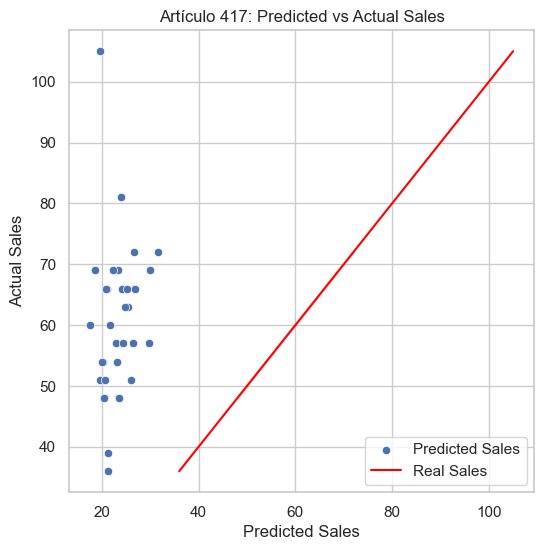

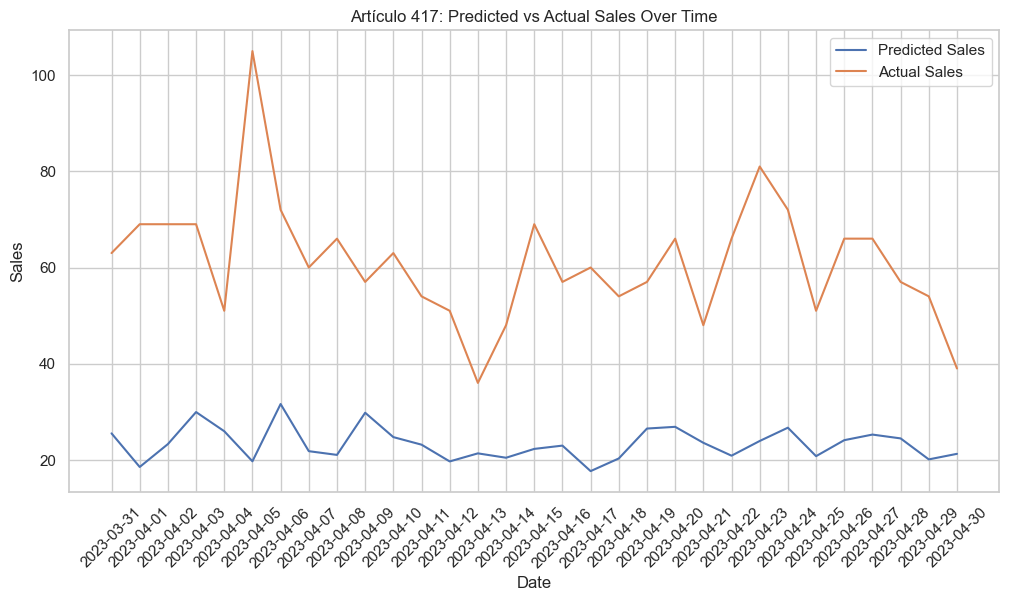


üé® Graficando art√≠culo 900...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


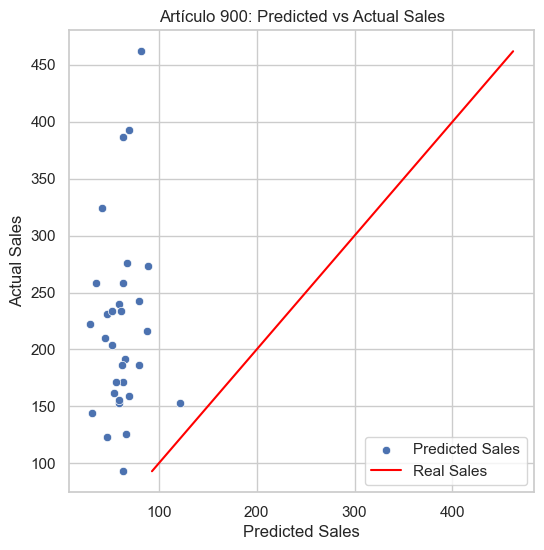

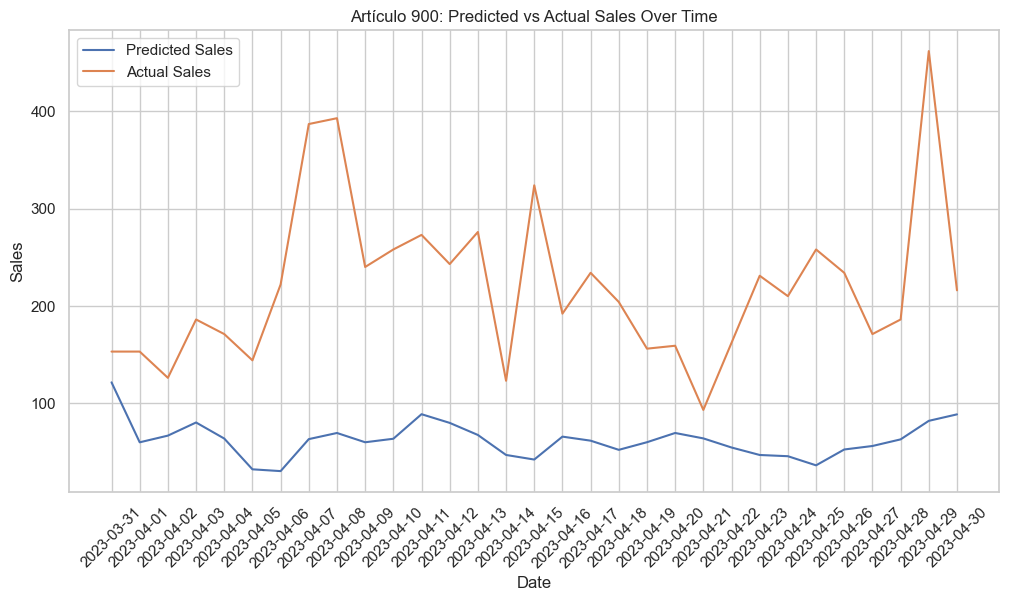


üé® Graficando art√≠culo 968...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


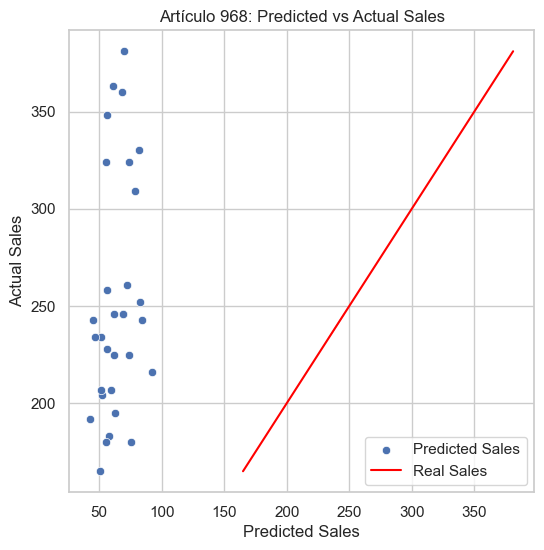

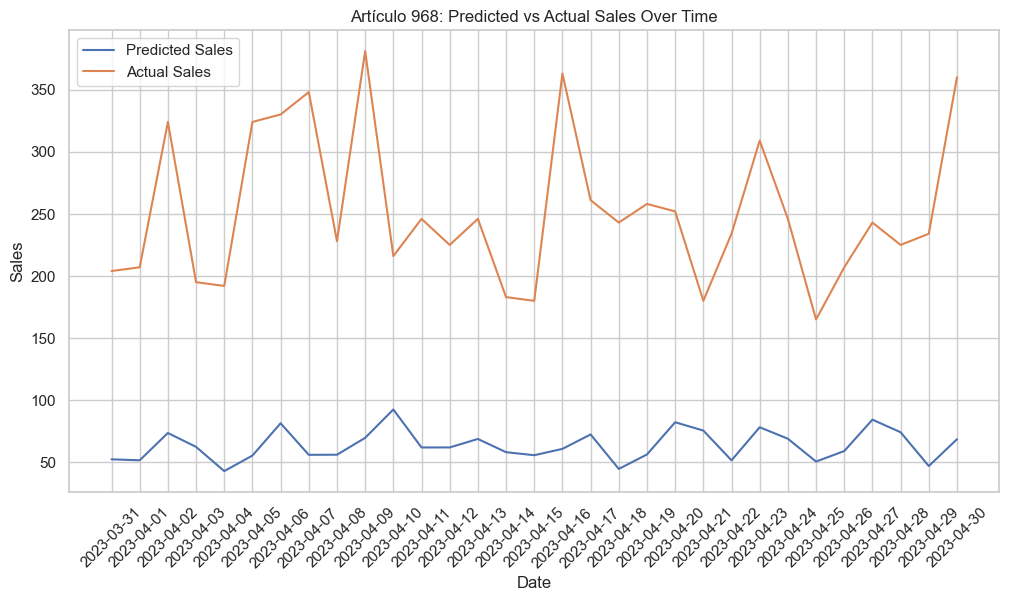


üé® Graficando art√≠culo 1043...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


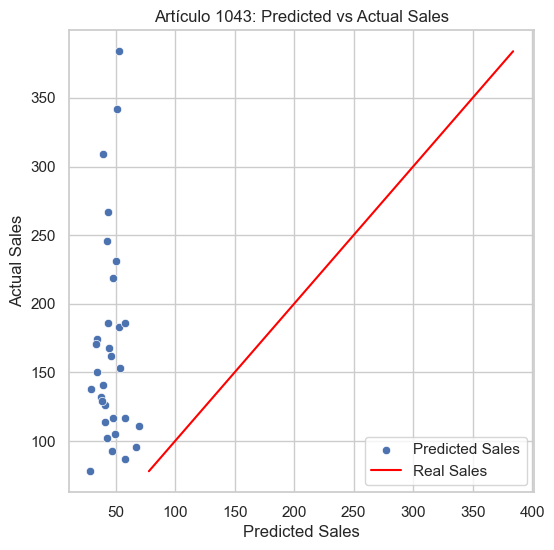

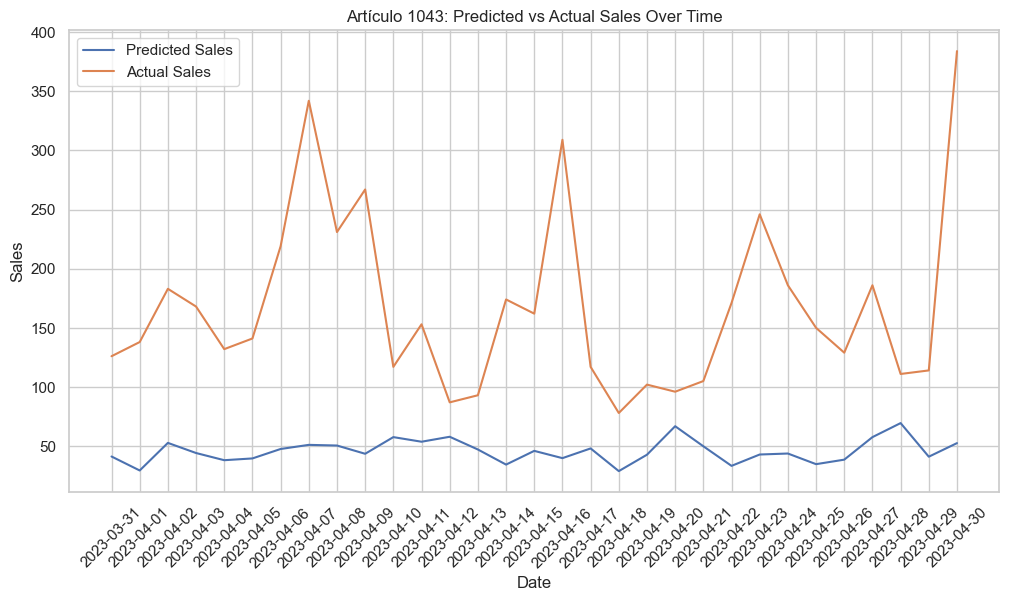


üé® Graficando art√≠culo 1084...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


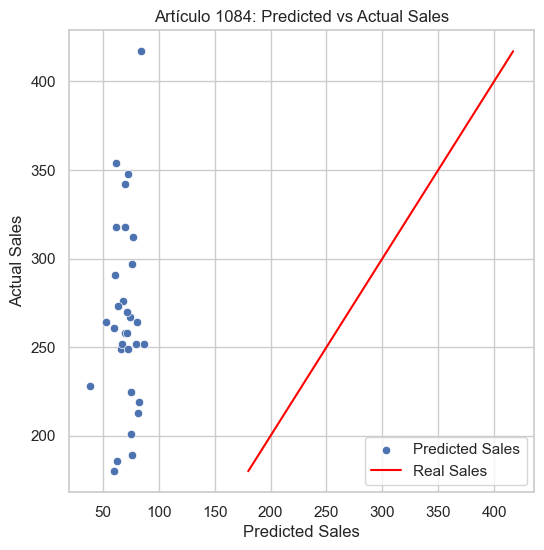

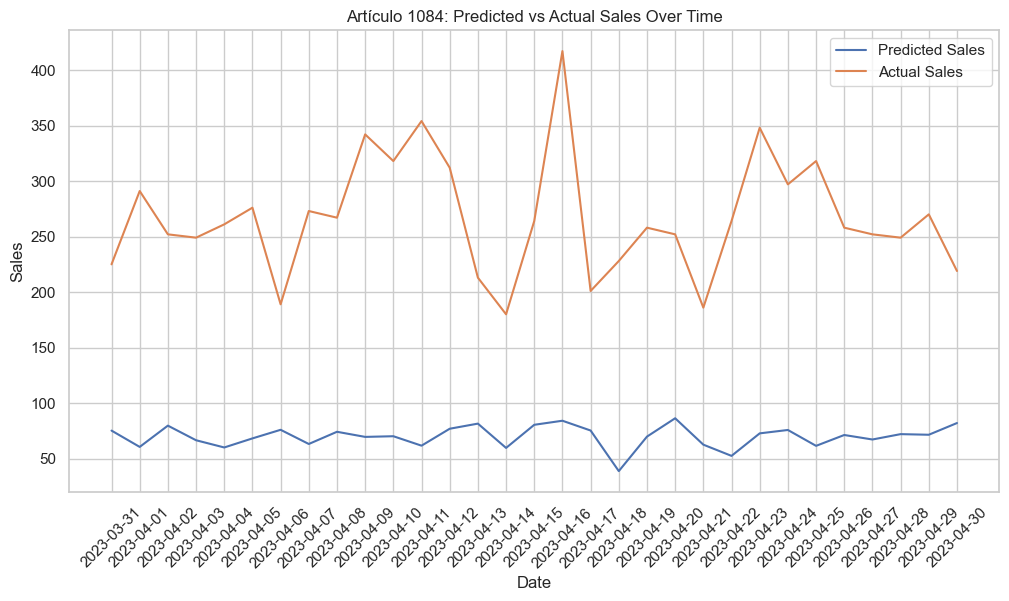


üé® Graficando art√≠culo 3880...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


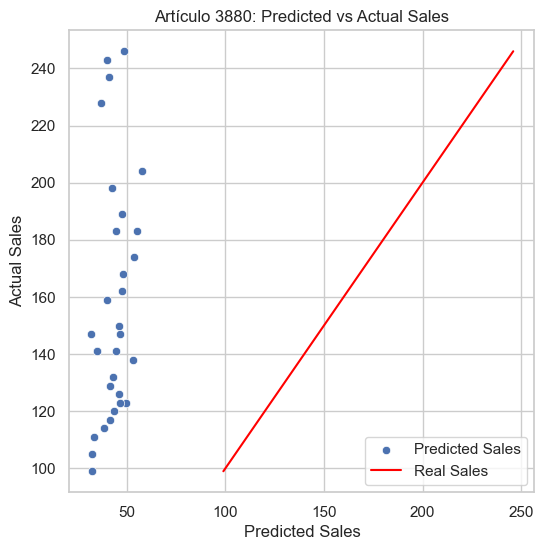

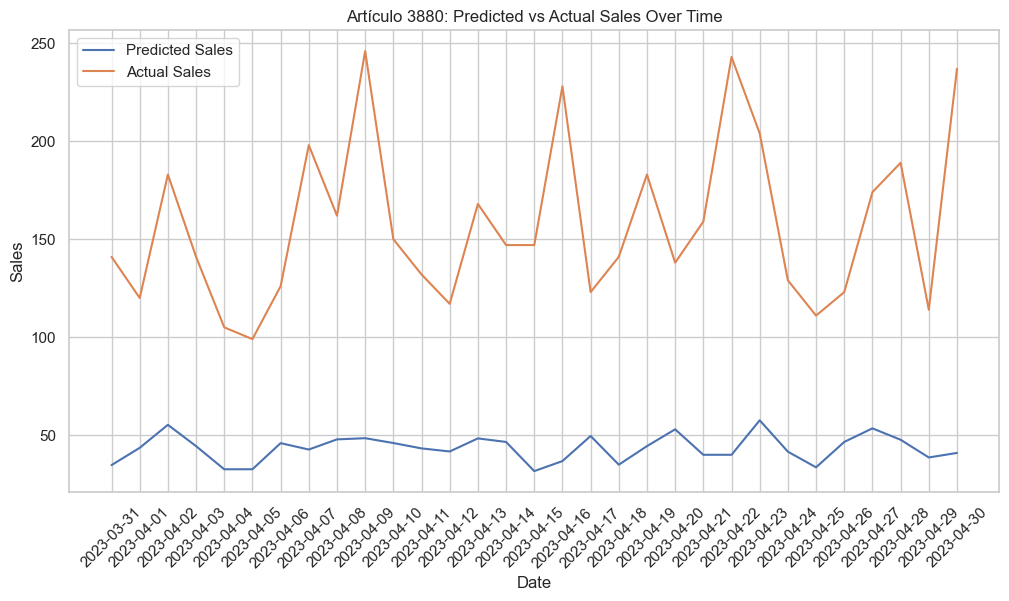


üé® Graficando art√≠culo 3960...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


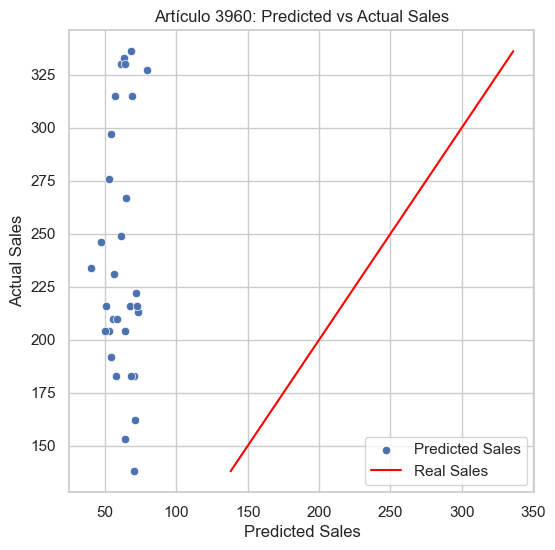

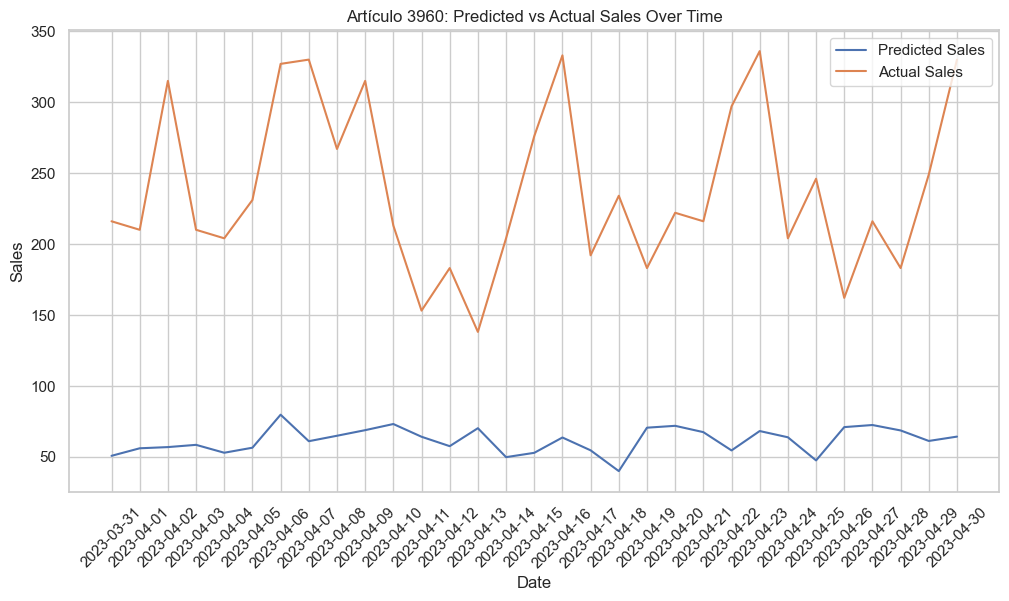


üé® Graficando art√≠culo 5403...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


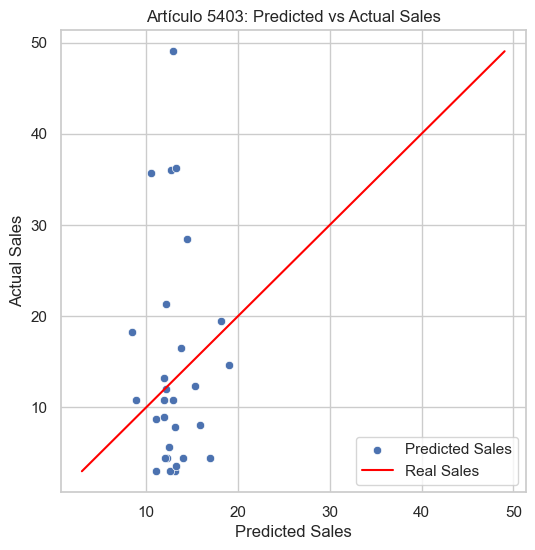

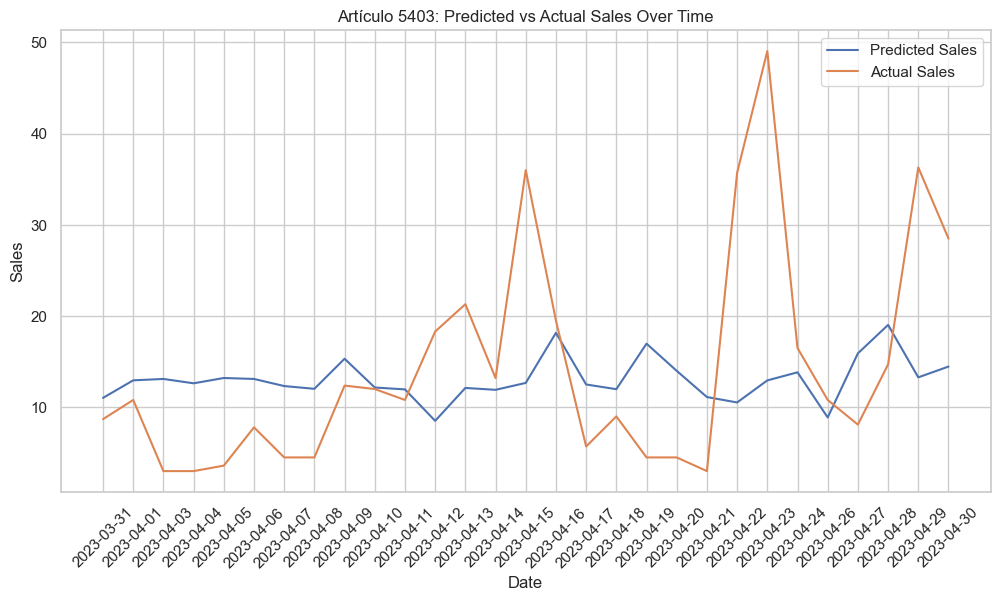


üé® Graficando art√≠culo 5404...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


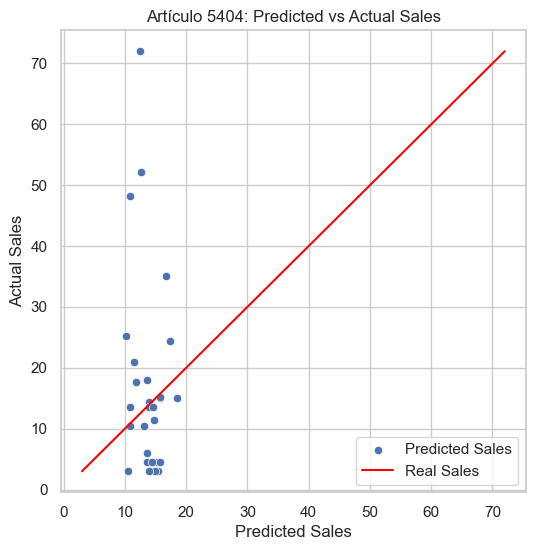

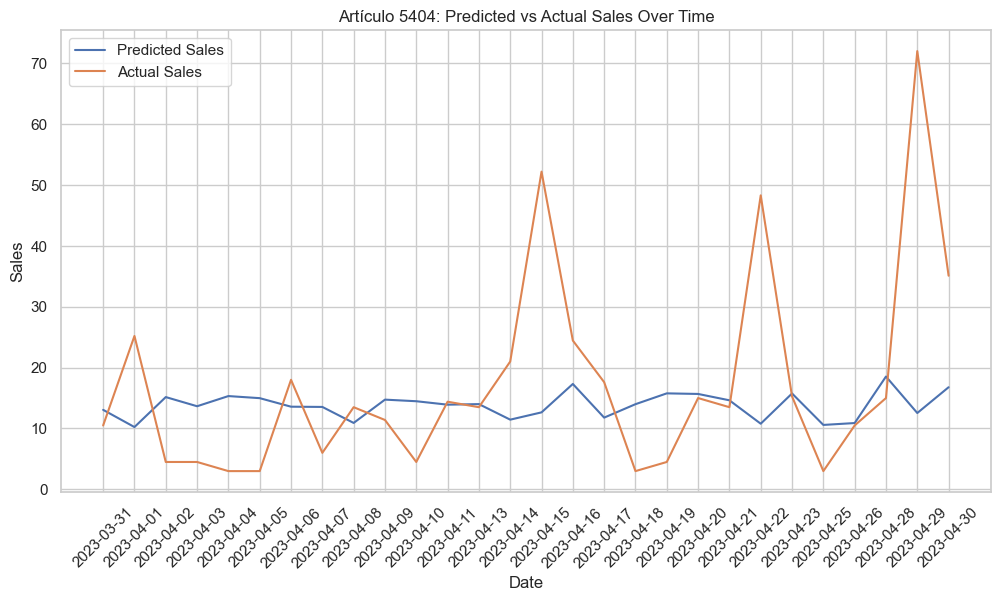


üé® Graficando art√≠culo 5803...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


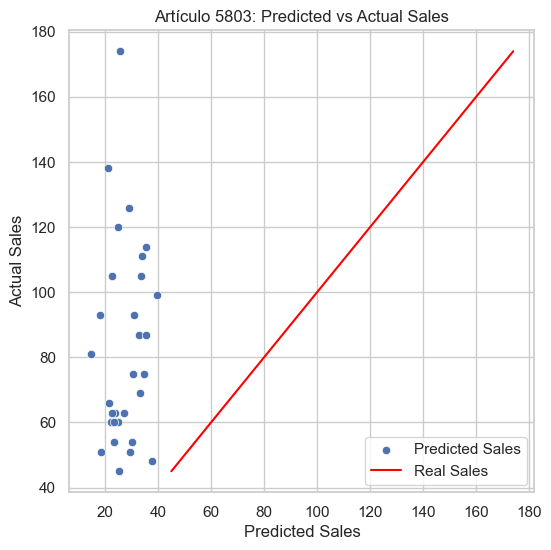

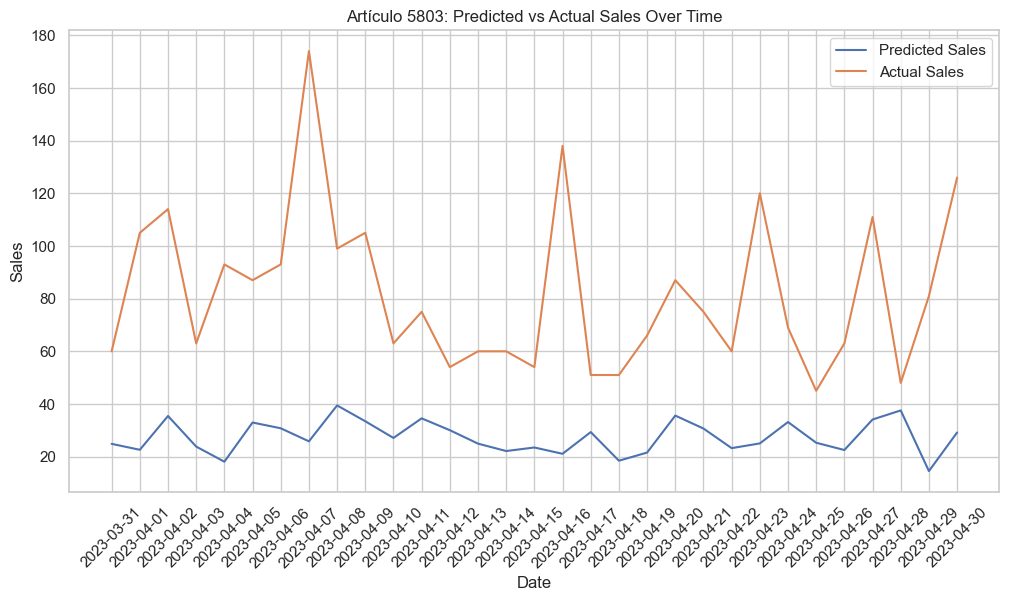


üé® Graficando art√≠culo 6286...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


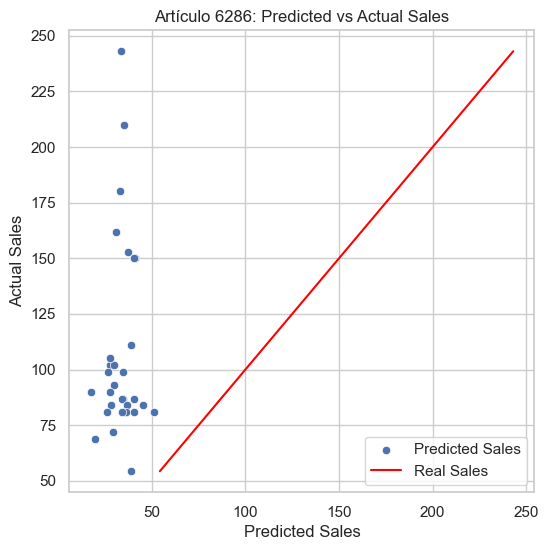

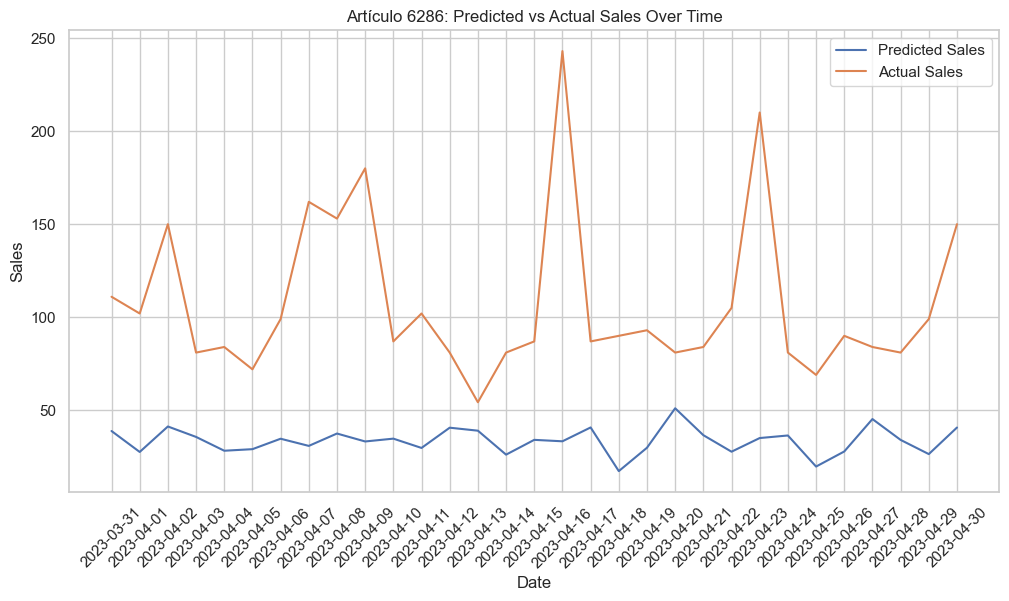


üé® Graficando art√≠culo 6425...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


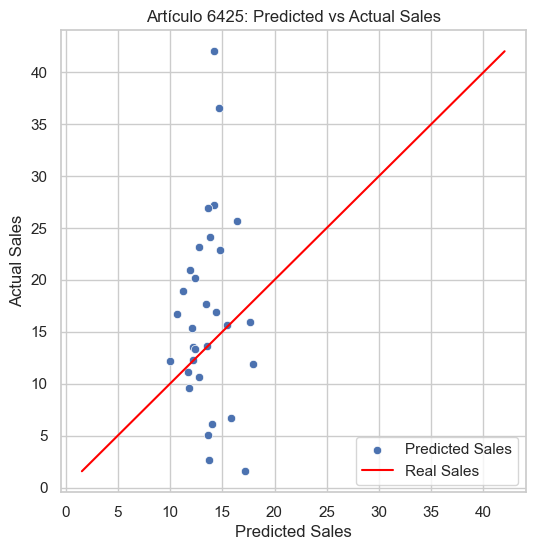

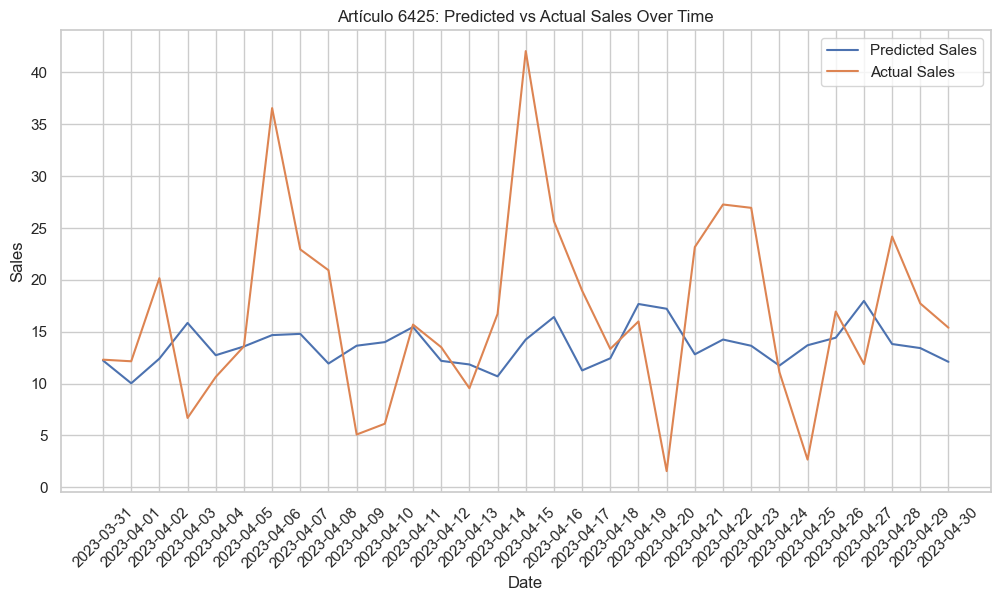


üé® Graficando art√≠culo 6451...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


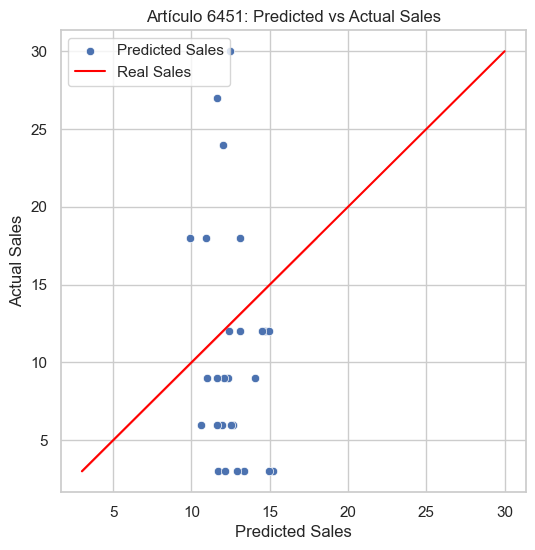

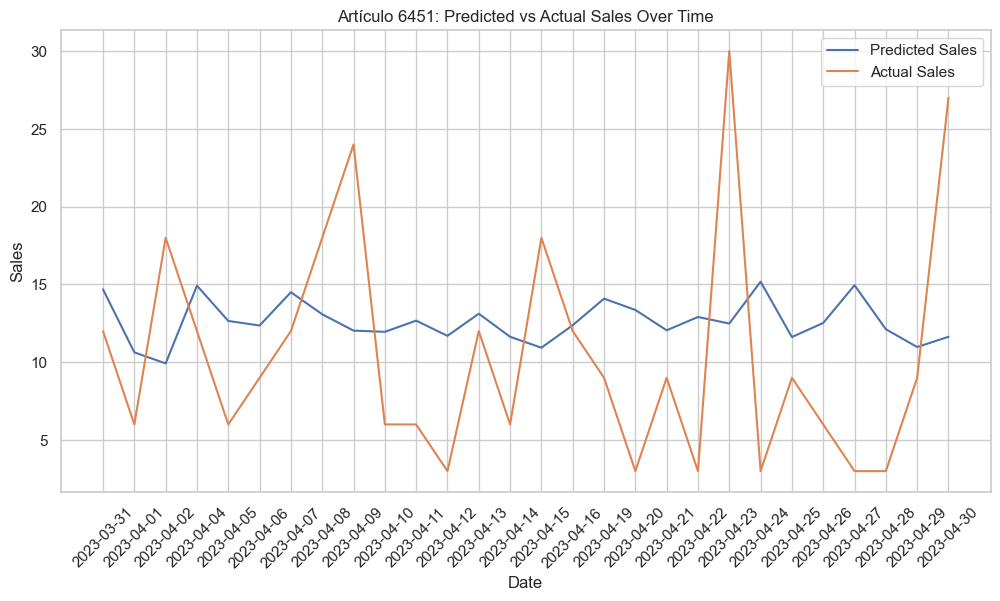


üé® Graficando art√≠culo 6523...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


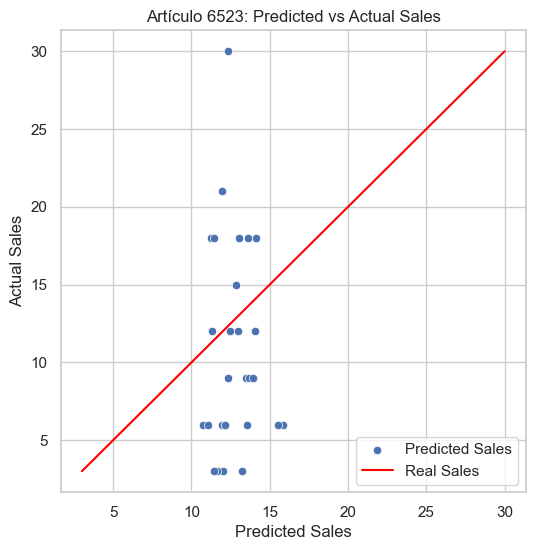

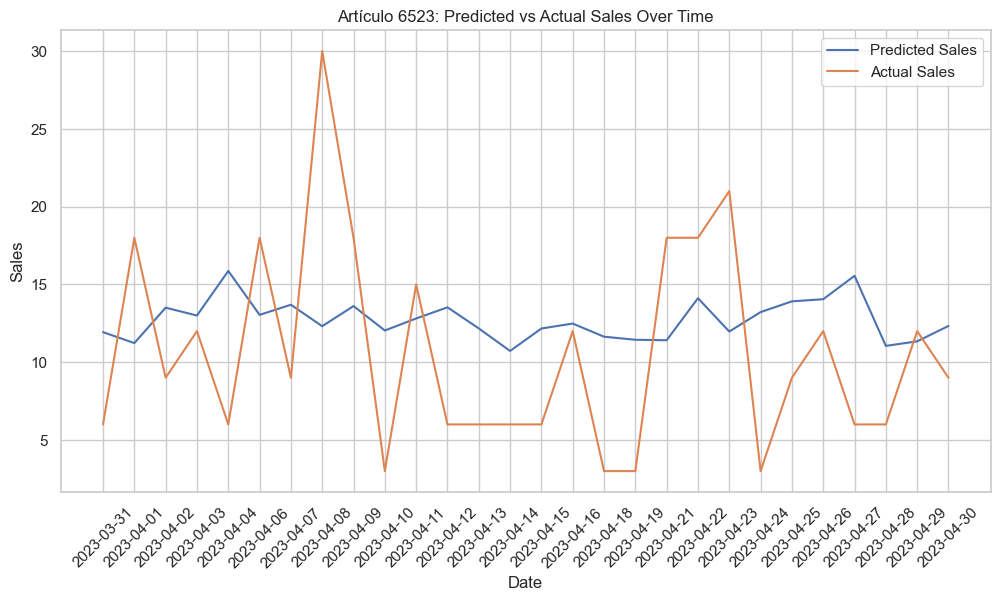


üé® Graficando art√≠culo 6549...
Advertencia: Columna 'festivo' no encontrada. No se marcar√°n festivos.


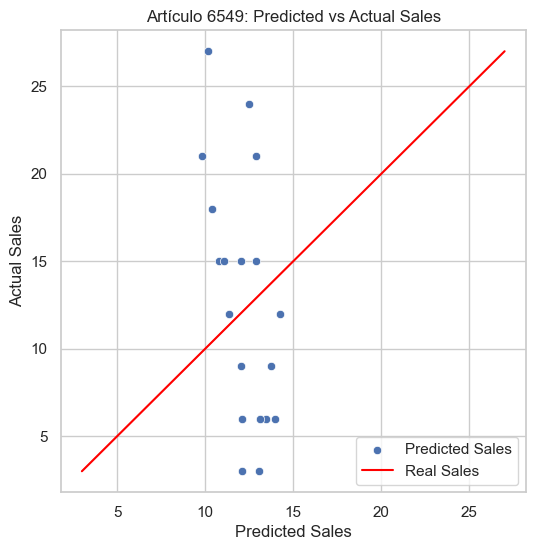

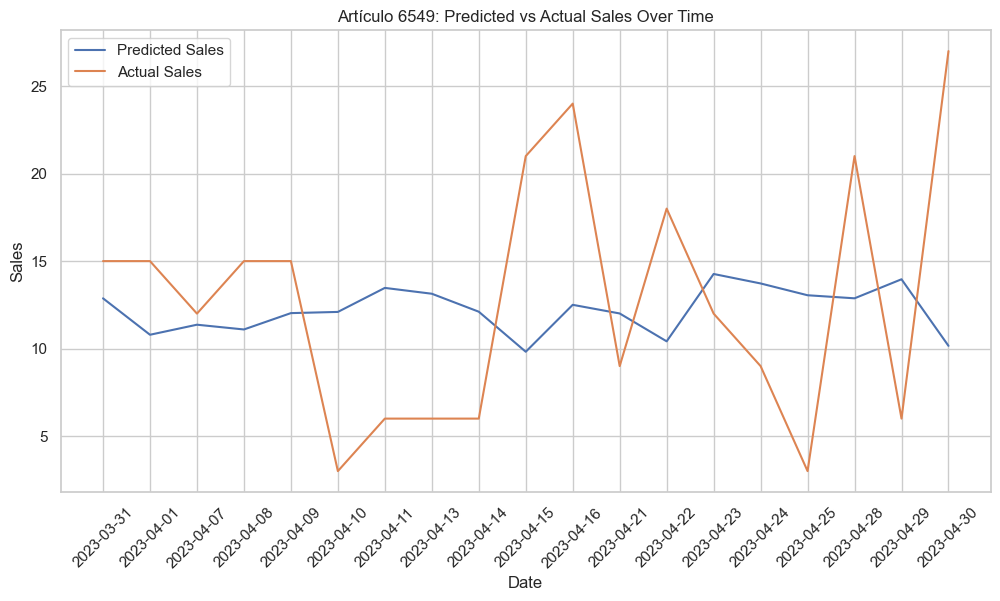

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

for id_articulo, datos_articulo in datos_preparados.items():
    print(f"\nüé® Graficando art√≠culo {id_articulo}...")

    X_test = datos_articulo["X_test"]
    y_test = datos_articulo["y_test"]

    if len(X_test) == 0:
        print(f"‚ö†Ô∏è Art√≠culo {id_articulo}: No hay datos de prueba para graficar.")
        continue

    # Predicci√≥n usando el modelo ya entrenado
    y_pred = final_pipeline.predict(X_test)

    # Obtener fechas para gr√°fico temporal (debe estar en el dataframe original)
    fechas = dfs_articulos[id_articulo].loc[X_test.index, 'fecha_venta'].astype(str)

    # --- Gr√°fico 1: Predicted vs Actual (scatter) ---
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f"Art√≠culo {id_articulo}: Predicted vs Actual Sales")
    ax.set_xlabel("Predicted Sales")
    ax.set_ylabel("Actual Sales")

    sns.scatterplot(x=y_pred, y=y_test, ax=ax, label="Predicted Sales")
    sns.lineplot(x=y_test, y=y_test, color="red", ax=ax, label="Real Sales")
    plt.legend()
    plt.show()

    # --- Gr√°fico 2: Evoluci√≥n temporal ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Art√≠culo {id_articulo}: Predicted vs Actual Sales Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.set_xticklabels(fechas, rotation=45)

    sns.lineplot(x=fechas, y=y_pred, label="Predicted Sales", ax=ax)
    sns.lineplot(x=fechas, y=y_test, label="Actual Sales", ax=ax)
    plt.legend()
    plt.show()
